In [76]:
import yfinance as yf
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# 🔑 FRED API Key 입력
fred = Fred(api_key='a49f63c44914cc9f7f72b42efd65b74c')  # ← 여기에 네 키를 넣어줘

# 1. GDP 데이터 (분기별, 단위: Billion USD)
gdp = fred.get_series('GDP')  # 명목 GDP (SAAR)
gdp = gdp.to_frame(name='gdp_billion')
gdp.index.name = 'date'
gdp['gdp'] = gdp['gdp_billion'] * 1_000_000_000  # → 달러 단위로 변환
gdp['quarter'] = gdp.index.to_period('Q').astype(str)
gdp = gdp.reset_index()
gdp.rename(columns={'date': 'date'}, inplace=True)

In [77]:
# 2. VTI 가격 데이터 (시가총액 직접 불가 → 종가 기준으로 추정)
vti = yf.Ticker("VTI")
vti_hist = vti.history(period="20y")
vti_hist = vti_hist.resample('QE').last()  # 분기별 종가
vti_hist = vti_hist[['Close']].rename(columns={'Close': 'vti_price'})
vti_hist.index.name = 'date'
vti_hist.index = vti_hist.index.tz_localize(None)
vti_hist['quarter'] = vti_hist.index.to_period('Q').astype(str)
vti_hist = vti_hist.reset_index()
vti_hist.rename(columns={'date': 'date'}, inplace=True)

# 3. 시가총액 추정: 최신 시가총액 기반 비례계산
latest_market_cap = vti.info['marketCap']
latest_price = vti.info['previousClose']
shares_outstanding = latest_market_cap / latest_price

# 각 분기의 시가총액 추정
vti_hist['vti_market_cap'] = vti_hist['vti_price'] * shares_outstanding

In [81]:
vti_hist

,date,vti_price,quarter,vti_market_cap
0,2005-03-31,39.924992,2005Q1,8.259472e+10
1,2005-06-30,40.868645,2005Q2,8.454690e+10
2,2005-09-30,42.528118,2005Q3,8.797993e+10
3,2005-12-31,43.453968,2005Q4,8.989528e+10
4,2006-03-31,45.873131,2006Q1,9.489992e+10
...,...,...,...,...
76,2024-03-31,257.356567,2024Q1,5.324057e+11
77,2024-06-30,265.831604,2024Q2,5.499384e+11
78,2024-09-30,282.251465,2024Q3,5.839070e+11
79,2024-12-31,289.809998,2024Q4,5.995437e+11


In [78]:
# 4. 버핏 지수 계산
merged = pd.merge(vti_hist, gdp, on='quarter', how='left')
merged['buffett_index'] = (merged['vti_market_cap'] / merged['gdp']) * 10000
merged.dropna(inplace=True)
merged

,date_x,vti_price,quarter,vti_market_cap,date_y,gdp_billion,gdp,buffett_index
0,2005-03-31,39.924992,2005Q1,8.259472e+10,2005-01-01,12767.286,1.276729e+13,64.692466
1,2005-06-30,40.868645,2005Q2,8.454690e+10,2005-04-01,12922.656,1.292266e+13,65.425328
2,2005-09-30,42.528118,2005Q3,8.797993e+10,2005-07-01,13142.642,1.314264e+13,66.942348
3,2005-12-31,43.453968,2005Q4,8.989528e+10,2005-10-01,13324.204,1.332420e+13,67.467656
4,2006-03-31,45.873131,2006Q1,9.489992e+10,2006-01-01,13599.160,1.359916e+13,69.783662
...,...,...,...,...,...,...,...,...
75,2023-12-31,234.075958,2023Q4,4.842440e+11,2023-10-01,28296.967,2.829697e+13,171.129302
76,2024-03-31,257.356567,2024Q1,5.324057e+11,2024-01-01,28624.069,2.862407e+13,185.999314
77,2024-06-30,265.831604,2024Q2,5.499384e+11,2024-04-01,29016.714,2.901671e+13,189.524709
78,2024-09-30,282.251465,2024Q3,5.839070e+11,2024-07-01,29374.914,2.937491e+13,198.777424


/var/folders/ww/prhhsq7100g92nt7xr4ltql5lkv223/T/ipykernel_87604/1008110663.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


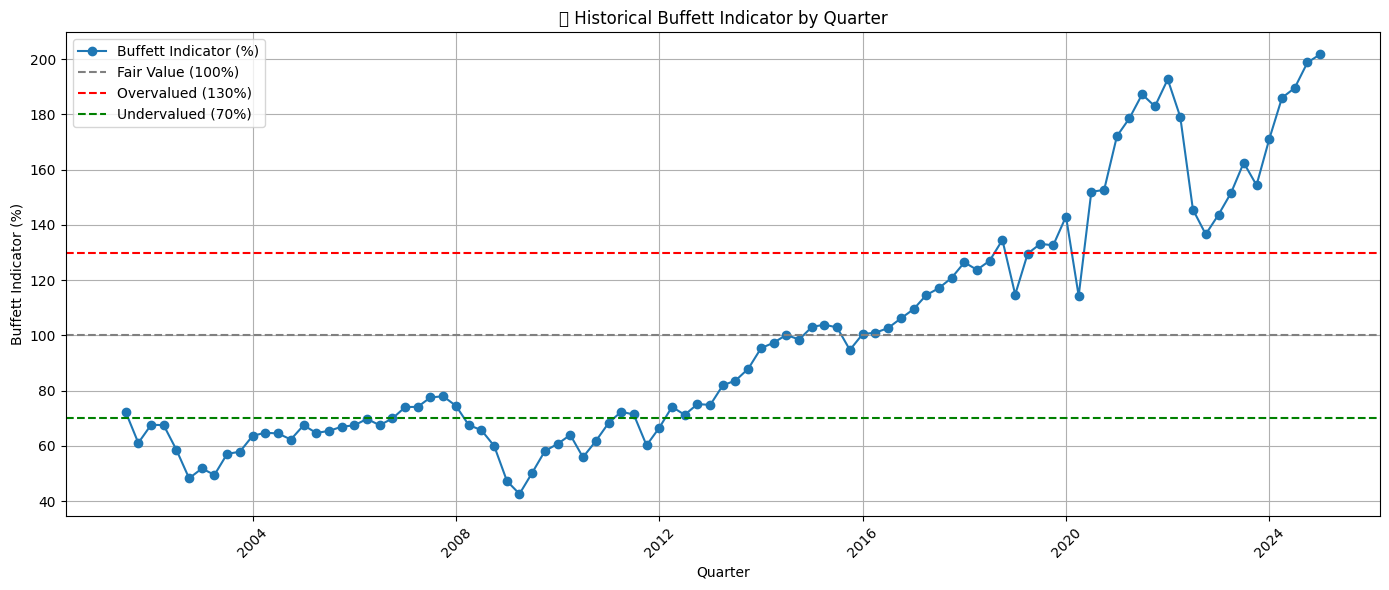

In [41]:
# 시각화
plt.figure(figsize=(14, 6))
plt.plot(merged['date_x'], merged['buffett_index'], marker='o', label='Buffett Indicator (%)')
plt.axhline(100, color='gray', linestyle='--', label='Fair Value (100%)')
plt.axhline(130, color='red', linestyle='--', label='Overvalued (130%)')
plt.axhline(70, color='green', linestyle='--', label='Undervalued (70%)')
plt.xticks(rotation=45)
plt.title('📊 Historical Buffett Indicator by Quarter')
plt.ylabel('Buffett Indicator (%)')
plt.xlabel('Quarter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
import yfinance as yf
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# 🔑 FRED API Key 입력
fred = Fred(api_key='a49f63c44914cc9f7f72b42efd65b74c')  # ← 여기에 네 키를 넣어줘

# 1. M2 데이터 (월간, billions of USD)
m2 = fred.get_series('M2SL')  # M2 Seasonally Adjusted
m2 = m2.to_frame(name='m2_billion')
m2.index.name = 'date'
m2['m2'] = m2['m2_billion'] * 1e9  # 달러 단위
m2 = m2.reset_index()
m2.rename(columns={'date': 'date'}, inplace=True)

In [83]:
m2

,date,m2_billion,m2
0,1959-01-01,286.6,2.866000e+11
1,1959-02-01,287.7,2.877000e+11
2,1959-03-01,289.2,2.892000e+11
3,1959-04-01,290.1,2.901000e+11
4,1959-05-01,292.2,2.922000e+11
...,...,...,...
788,2024-09-01,21252.4,2.125240e+13
789,2024-10-01,21332.7,2.133270e+13
790,2024-11-01,21465.8,2.146580e+13
791,2024-12-01,21549.3,2.154930e+13


In [84]:
# 2. VTI 가격 (yfinance, 월말 종가)
vti = yf.Ticker("VTI")
vti_hist = vti.history(period="20y")
vti_hist = vti_hist.resample('ME').last()  # 월별 종가
vti_hist = vti_hist[['Close']].rename(columns={'Close': 'vti_price'})
vti_hist.index = vti_hist.index + pd.Timedelta(days=1)
vti_hist.index.name = 'date'
vti_hist.index = vti_hist.index.tz_localize(None)
vti_hist = vti_hist.reset_index()
vti_hist.rename(columns={'date': 'date'}, inplace=True)

# 3. 시가총액 추정: 최신 시가총액 기반 비례계산
latest_market_cap = vti.info['marketCap']
latest_price = vti.info['previousClose']
shares_outstanding = latest_market_cap / latest_price

# 시가총액 추정
vti_hist['vti_market_cap'] = vti_hist['vti_price'] * shares_outstanding

In [85]:
vti_hist

,date,vti_price,vti_market_cap
0,2005-04-01,39.924995,8.259473e+10
1,2005-05-01,39.045559,8.077540e+10
2,2005-06-01,40.561104,8.391068e+10
3,2005-07-01,40.868645,8.454690e+10
4,2005-08-01,42.657963,8.824855e+10
...,...,...,...
236,2024-12-01,298.897888,6.183442e+11
237,2025-01-01,289.809998,5.995437e+11
238,2025-02-01,298.600006,6.177280e+11
239,2025-03-01,292.959991,6.060602e+11


In [72]:
# 4. 지수 계산
merged = pd.merge(vti_hist, m2, on='date', how='left')
merged['m2_per_marketcap'] = merged['m2'] / merged['vti_market_cap']
merged.dropna(inplace=True)
merged

,date,vti_price,vti_market_cap,m2_billion,m2,m2_per_marketcap
0,2005-04-01,39.924992,8.259472e+10,6462.0,6.462000e+12,78.237446
1,2005-05-01,39.045578,8.077544e+10,6479.2,6.479200e+12,80.212504
2,2005-06-01,40.561092,8.391065e+10,6511.8,6.511800e+12,77.603973
3,2005-07-01,40.868660,8.454693e+10,6543.7,6.543700e+12,77.397249
4,2005-08-01,42.657974,8.824857e+10,6576.5,6.576500e+12,74.522453
...,...,...,...,...,...,...
233,2024-09-01,276.633392,5.722846e+11,21252.4,2.125240e+13,37.136068
234,2024-10-01,282.251465,5.839070e+11,21332.7,2.133270e+13,36.534416
235,2024-11-01,280.128296,5.795147e+11,21465.8,2.146580e+13,37.040995
236,2024-12-01,298.897888,6.183442e+11,21549.3,2.154930e+13,34.850007


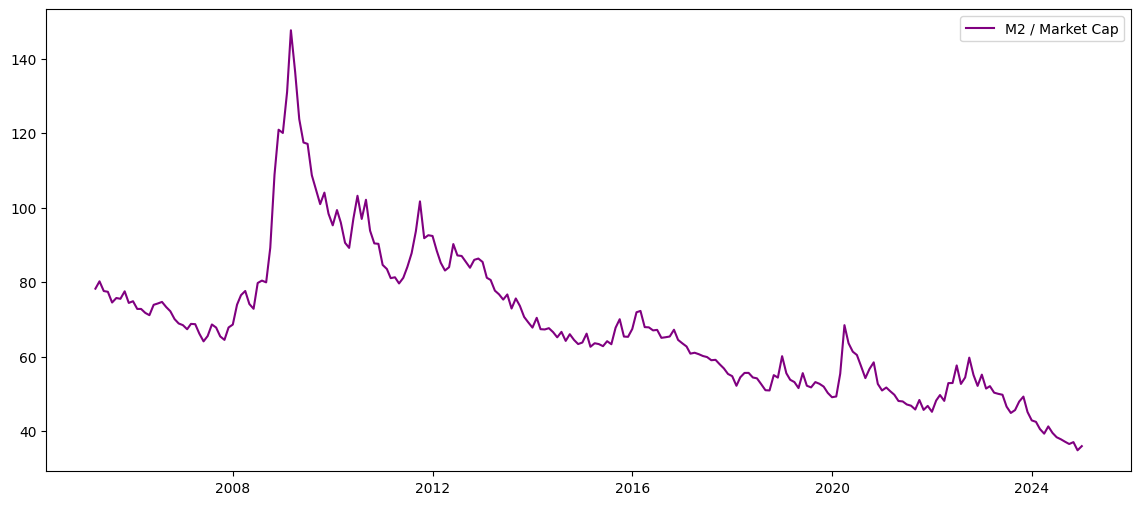

In [75]:
plt.figure(figsize=(14, 6))
plt.plot(merged['date'], merged['m2_per_marketcap'], label='M2 / Market Cap', color='purple')
plt.legend()
plt.show()

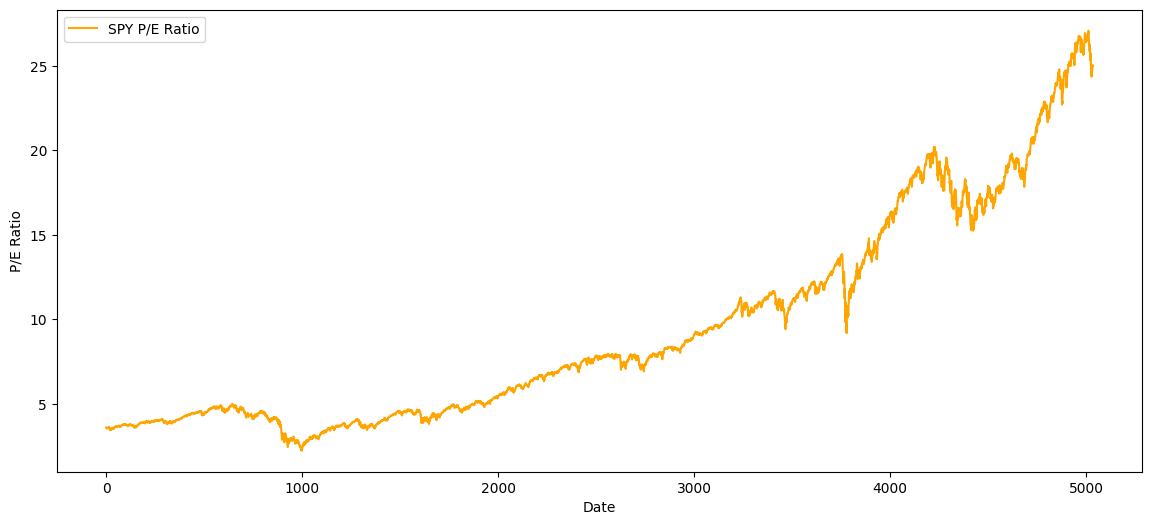

In [95]:
# 1. SPY 정보 불러오기
spy = yf.Ticker("SPY")
info = spy.info

# 2. 현재 가격과 trailing PER 가져오기
price = info.get('previousClose')
pe = info.get('trailingPE')

if not price or not pe:
    raise ValueError("❌ 가격 또는 PER 정보가 없습니다.")

# 3. EPS 추정
eps = price / pe

# 4. SPY 가격 데이터 (20년치)
price_df = spy.history(period="20y")
price_df = price_df[['Close']].rename(columns={'Close': 'spy_price'})
price_df = price_df.reset_index()
price_df.rename(columns={'Date': 'date'}, inplace=True)

# 5. P/E Ratio 계산
price_df['pe_ratio'] = price_df['spy_price'] / eps

# 6. 시각화
plt.figure(figsize=(14, 6))
plt.plot(price_df.index, price_df['pe_ratio'], color='orange', label='SPY P/E Ratio')
plt.xlabel('Date')
plt.ylabel('P/E Ratio')
plt.legend()
plt.show()

In [96]:
price_df

,date,spy_price,pe_ratio
0,2005-03-21 00:00:00-05:00,81.372757,3.595500
1,2005-03-22 00:00:00-05:00,80.545952,3.558967
2,2005-03-23 00:00:00-05:00,80.614822,3.562010
3,2005-03-24 00:00:00-05:00,80.711288,3.566273
4,2005-03-28 00:00:00-05:00,80.828453,3.571450
...,...,...,...
5028,2025-03-14 00:00:00-04:00,562.809998,24.868070
5029,2025-03-17 00:00:00-04:00,567.150024,25.059837
5030,2025-03-18 00:00:00-04:00,561.020020,24.788979
5031,2025-03-19 00:00:00-04:00,567.130005,25.058952


In [94]:
price_df = price_df.reset_index()
price_df.rename(columns={'Date': 'date'}, inplace=True)
price_df

,date,spy_price,pe_ratio
0,2005-03-21 00:00:00-05:00,81.372742,3.595499
1,2005-03-22 00:00:00-05:00,80.545975,3.558968
2,2005-03-23 00:00:00-05:00,80.614868,3.562012
3,2005-03-24 00:00:00-05:00,80.711327,3.566275
4,2005-03-28 00:00:00-05:00,80.828430,3.571449
...,...,...,...
5028,2025-03-14 00:00:00-04:00,562.809998,24.868070
5029,2025-03-17 00:00:00-04:00,567.150024,25.059837
5030,2025-03-18 00:00:00-04:00,561.020020,24.788979
5031,2025-03-19 00:00:00-04:00,567.130005,25.058952
